# Statistically improving my League of Legends Gameplay
Diego Perez

U of U

DS 2500

April 30, 2024

# Question
What components of my League of Legends gameplay contribute to getting more assists?

# Necessary Imports

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from scipy.stats import pearsonr # pearson correlation
import statsmodels.formula.api as smf
import time

# Using Riot API to gather data, Invetigating data, and Cleaning Data

**Important:** This section does not need to be run again as all of the data gathered is saved into a github repository. This is just to show how the data was gathered. In order to run this section again, a Riot API key must be provided

## Import Riot API, Enter Credentials, and Quick API Test

In [30]:
!pip install riotwatcher

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 1.2 MB/s eta 0:00:00


In [31]:
from riotwatcher import LolWatcher, ApiError

In [32]:
lol_watcher = LolWatcher('ENTER API KEY HERE') #this only lasts 1 day!

In [34]:
#Test on me to ensure API is working
my_region = 'na1'
me = lol_watcher.summoner.by_puuid(my_region, '2Y4LhX8oypLO-uT7Zzul27RgBhij4TlcilXJW6hhPHKTQY4N4M8j02kUcwTkxYmEPS9gw6-K4hZgag')
my_ranked_stats = lol_watcher.league.by_summoner(my_region, me['id'])
print(my_ranked_stats)

[{'leagueId': '93e48363-5e1e-456e-b3dc-9dd3e636c5df', 'queueType': 'RANKED_SOLO_5x5', 'tier': 'PLATINUM', 'rank': 'IV', 'summonerId': 'HLEwS5o-gbnvf_qzrN0vG2lA_LwImZGV1rhwpiGWxMP-eTE', 'leaguePoints': 0, 'wins': 8, 'losses': 4, 'veteran': False, 'inactive': False, 'freshBlood': False, 'hotStreak': False}]


## Gather Data

In [35]:
my_puuid = '2Y4LhX8oypLO-uT7Zzul27RgBhij4TlcilXJW6hhPHKTQY4N4M8j02kUcwTkxYmEPS9gw6-K4hZgag'
matches = lol_watcher.match.matchlist_by_puuid(my_region, my_puuid, 0, 100)
print(matches)

['NA1_4987202469', 'NA1_4987163713', 'NA1_4987111125', 'NA1_4983637578', 'NA1_4983623923', 'NA1_4981156763', 'NA1_4981142048', 'NA1_4981112404', 'NA1_4976666822', 'NA1_4976662111', 'NA1_4976632145', 'NA1_4976607227', 'NA1_4975106292', 'NA1_4975086545', 'NA1_4970858275', 'NA1_4970843153', 'NA1_4970052477', 'NA1_4970039970', 'NA1_4967595909', 'NA1_4967569029', 'NA1_4966659483', 'NA1_4966639988', 'NA1_4961551230', 'NA1_4960686736', 'NA1_4960668947', 'NA1_4960642301', 'NA1_4960613809', 'NA1_4953020920', 'NA1_4952999988', 'NA1_4952979465', 'NA1_4952960870', 'NA1_4952931297', 'NA1_4952896623', 'NA1_4952876361', 'NA1_4944392052', 'NA1_4944377142', 'NA1_4944365943', 'NA1_4943581601', 'NA1_4943568202', 'NA1_4943535552', 'NA1_4943509402', 'NA1_4943491304', 'NA1_4943468691', 'NA1_4943460968', 'NA1_4943448854', 'NA1_4943403501', 'NA1_4943383531', 'NA1_4943368260', 'NA1_4943352372', 'NA1_4942714424', 'NA1_4942698356', 'NA1_4942678789', 'NA1_4942649911', 'NA1_4942611816', 'NA1_4941089103', 'NA1_4941

In [36]:
tempMatches = []
for m in matches:
  tempMatches.append(lol_watcher.match.by_id(my_region,m))
myMatchData = []

In [37]:
for tempMatch in tempMatches:
  if(tempMatch['info']['gameMode'] != 'CLASSIC'): #Avoid any games that aren't Normal Gamemode
    continue
  for i in range(10): #Go through all 10 players and find me
    try:
      player_data = tempMatch['info']['participants'][i]
      if(player_data['puuid'] == my_puuid):
        myMatchData.append(player_data)
    except:
      continue
print(myMatchData)

[{'allInPings': 0, 'assistMePings': 0, 'assists': 11, 'baronKills': 0, 'basicPings': 0, 'bountyLevel': 0, 'challenges': {'12AssistStreakCount': 0, 'abilityUses': 99, 'acesBefore15Minutes': 0, 'alliedJungleMonsterKills': 0, 'baronTakedowns': 0, 'blastConeOppositeOpponentCount': 0, 'bountyGold': 0, 'buffsStolen': 0, 'completeSupportQuestInTime': 0, 'controlWardsPlaced': 0, 'damagePerMinute': 142.13931479329182, 'damageTakenOnTeamPercentage': 0.1468389112663954, 'dancedWithRiftHerald': 0, 'deathsByEnemyChamps': 7, 'dodgeSkillShotsSmallWindow': 0, 'doubleAces': 0, 'dragonTakedowns': 0, 'earlyLaningPhaseGoldExpAdvantage': 0, 'effectiveHealAndShielding': 2224.74267578125, 'elderDragonKillsWithOpposingSoul': 0, 'elderDragonMultikills': 0, 'enemyChampionImmobilizations': 18, 'enemyJungleMonsterKills': 0, 'epicMonsterKillsNearEnemyJungler': 0, 'epicMonsterKillsWithin30SecondsOfSpawn': 0, 'epicMonsterSteals': 0, 'epicMonsterStolenWithoutSmite': 0, 'firstTurretKilled': 0, 'flawlessAces': 0, 'full

In [38]:
print(len(myMatchData))

180


## Read in the data

In [39]:
myMatchesDf = pd.DataFrame(myMatchData)

## Check the packaging

In [63]:
myMatchesDf.shape

(74, 98)

## Check the top and bottom

In [40]:
myMatchesDf.head()

,allInPings,assistMePings,assists,baronKills,basicPings,bountyLevel,challenges,champExperience,champLevel,championId,...,playerScore2,playerScore3,playerScore4,playerScore5,playerScore6,playerScore7,playerScore8,playerScore9,baitPings,riotIdName
0,0,0,11,0,0,0,"{'12AssistStreakCount': 0, 'abilityUses': 99, ...",8583,12,497,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,21,0,0,0,"{'12AssistStreakCount': 1, 'abilityUses': 123,...",12461,14,888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,15,0,0,3,"{'12AssistStreakCount': 1, 'abilityUses': 174,...",18381,18,888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,8,0,0,13,"{'12AssistStreakCount': 0, 'abilityUses': 174,...",12754,14,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,7,0,0,0,"{'12AssistStreakCount': 0, 'abilityUses': 114,...",10143,13,57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
myMatchesDf.tail()

,allInPings,assistMePings,assists,baronKills,basicPings,bountyLevel,challenges,champExperience,champLevel,championId,...,playerScore2,playerScore3,playerScore4,playerScore5,playerScore6,playerScore7,playerScore8,playerScore9,baitPings,riotIdName
175,0,0,10,0,0,0,"{'12AssistStreakCount': 0, 'abilityUses': 110,...",12980,14,555,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,
176,0,1,4,0,0,2,"{'12AssistStreakCount': 0, 'abilityUses': 45, ...",4909,8,555,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,
177,0,0,6,0,0,7,"{'12AssistStreakCount': 0, 'abilityUses': 169,...",26316,18,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,
178,0,0,7,0,0,10,"{'12AssistStreakCount': 0, 'abilityUses': 152,...",20515,18,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,
179,0,0,2,0,0,0,"{'12AssistStreakCount': 0, 'abilityUses': 76, ...",8161,11,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,


## Cleaning The Data

In [42]:
print(myMatchesDf.columns.values)

['allInPings' 'assistMePings' 'assists' 'baronKills' 'basicPings'
 'bountyLevel' 'challenges' 'champExperience' 'champLevel' 'championId'
 'championName' 'championTransform' 'commandPings' 'consumablesPurchased'
 'damageDealtToBuildings' 'damageDealtToObjectives' 'damageDealtToTurrets'
 'damageSelfMitigated' 'dangerPings' 'deaths' 'detectorWardsPlaced'
 'doubleKills' 'dragonKills' 'eligibleForProgression' 'enemyMissingPings'
 'enemyVisionPings' 'firstBloodAssist' 'firstBloodKill' 'firstTowerAssist'
 'firstTowerKill' 'gameEndedInEarlySurrender' 'gameEndedInSurrender'
 'getBackPings' 'goldEarned' 'goldSpent' 'holdPings' 'individualPosition'
 'inhibitorKills' 'inhibitorTakedowns' 'inhibitorsLost' 'item0' 'item1'
 'item2' 'item3' 'item4' 'item5' 'item6' 'itemsPurchased' 'killingSprees'
 'kills' 'lane' 'largestCriticalStrike' 'largestKillingSpree'
 'largestMultiKill' 'longestTimeSpentLiving' 'magicDamageDealt'
 'magicDamageDealtToChampions' 'magicDamageTaken' 'missions'
 'needVisionPings' '

In [43]:
myMatchesDf.drop(['challenges', 'item0','item1','item2','item3','item4','item5','item6','missions','spell1Casts','spell2Casts','spell3Casts','spell4Casts',
                  'playerAugment1','playerAugment2','playerAugment3','playerAugment4','playerSubteamId','profileIcon','puuid','riotIdGameName','riotIdTagline',
                  'championId','eligibleForProgression','itemsPurchased','participantId','subteamPlacement','summoner1Casts','summoner1Id','summoner2Casts',
                  'summoner2Id','summonerId','teamId', 'playerScore0','playerScore1','playerScore2','playerScore3','playerScore4','playerScore5',
                  'playerScore6','playerScore7','playerScore8','playerScore9','playerScore10','playerScore11'], axis=1, inplace=True)

In [44]:
myMatchesDf.head()

,allInPings,assistMePings,assists,baronKills,basicPings,bountyLevel,champExperience,champLevel,championName,championTransform,...,turretsLost,unrealKills,visionClearedPings,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,baitPings,riotIdName
0,0,0,11,0,0,0,8583,12,Rakan,0,...,7,0,0,50,0,5,19,False,NaN,NaN
1,0,2,21,0,0,0,12461,14,Renata,0,...,11,0,0,51,0,3,21,False,NaN,NaN
2,0,0,15,0,0,3,18381,18,Renata,0,...,8,0,0,100,2,13,41,True,NaN,NaN
3,0,0,8,0,0,13,12754,14,Swain,0,...,0,0,0,29,0,2,12,True,NaN,NaN
4,0,0,7,0,0,0,10143,13,Maokai,0,...,10,0,0,43,0,5,16,False,NaN,NaN


In [45]:
print(myMatchesDf.columns.values)

['allInPings' 'assistMePings' 'assists' 'baronKills' 'basicPings'
 'bountyLevel' 'champExperience' 'champLevel' 'championName'
 'championTransform' 'commandPings' 'consumablesPurchased'
 'damageDealtToBuildings' 'damageDealtToObjectives' 'damageDealtToTurrets'
 'damageSelfMitigated' 'dangerPings' 'deaths' 'detectorWardsPlaced'
 'doubleKills' 'dragonKills' 'enemyMissingPings' 'enemyVisionPings'
 'firstBloodAssist' 'firstBloodKill' 'firstTowerAssist' 'firstTowerKill'
 'gameEndedInEarlySurrender' 'gameEndedInSurrender' 'getBackPings'
 'goldEarned' 'goldSpent' 'holdPings' 'individualPosition'
 'inhibitorKills' 'inhibitorTakedowns' 'inhibitorsLost' 'killingSprees'
 'kills' 'lane' 'largestCriticalStrike' 'largestKillingSpree'
 'largestMultiKill' 'longestTimeSpentLiving' 'magicDamageDealt'
 'magicDamageDealtToChampions' 'magicDamageTaken' 'needVisionPings'
 'neutralMinionsKilled' 'nexusKills' 'nexusLost' 'nexusTakedowns'
 'objectivesStolen' 'objectivesStolenAssists' 'onMyWayPings' 'pentaKills

## Check the n's

Make sure we have enough assists data to go off of

In [64]:
myMatchesDf['assists'].count()

74

## Validate Against External Source

We should expect to see between 1 and 30 assists on average

In [65]:
myMatchesDf['assists']

0      8
1      7
2      7
3     22
4     10
      ..
69    12
70     9
71    17
72    11
73    18
Name: assists, Length: 74, dtype: int64

## Export to CSV for quick use later on

In [46]:
myMatchesDf.to_csv('myMatchesData')

# Exploration & Linear Regression Model

## Quick Read in using previously gathered data from the API above

In [2]:
myMatchesDf = pd.read_csv("https://github.com/Dpere22/Spring2024DataScience/raw/main/FinalProject/myMatchesData.csv")

## Create Visualizations

Check to see what variables are evenly distributed

array([[<Axes: title={'center': 'visionScore'}>,
        <Axes: title={'center': 'wardsPlaced'}>],
       [<Axes: title={'center': 'turretsLost'}>,
        <Axes: title={'center': 'turretTakedowns'}>],
       [<Axes: title={'center': 'totalDamageShieldedOnTeammates'}>,
        <Axes: title={'center': 'totalDamageTaken'}>],
       [<Axes: title={'center': 'totalDamageDealt'}>,
        <Axes: title={'center': 'totalHeal'}>],
       [<Axes: title={'center': 'goldEarned'}>,
        <Axes: title={'center': 'timePlayed'}>]], dtype=object)

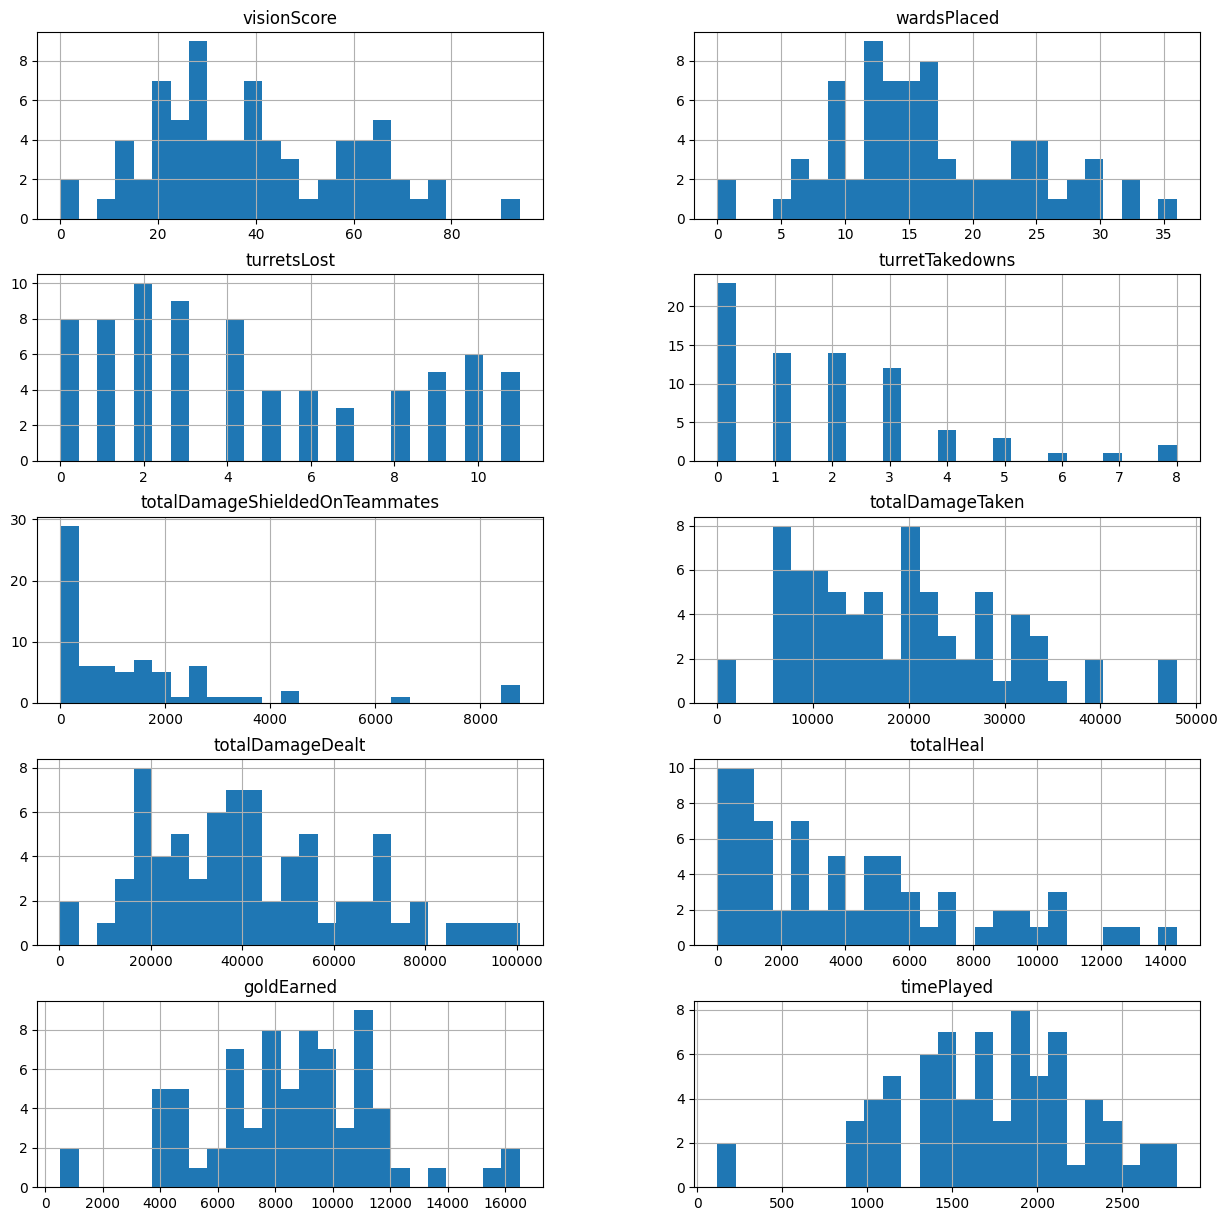

In [3]:
myMatchesDf[['visionScore','wardsPlaced','turretsLost','turretTakedowns','totalDamageShieldedOnTeammates','totalDamageTaken','totalDamageDealt','totalHeal',
             'goldEarned','timePlayed']].hist(bins=25,layout=(5,2),figsize=(15,15))

Graph to understand the data that is evenly distributed to see if there might be some linear relationship

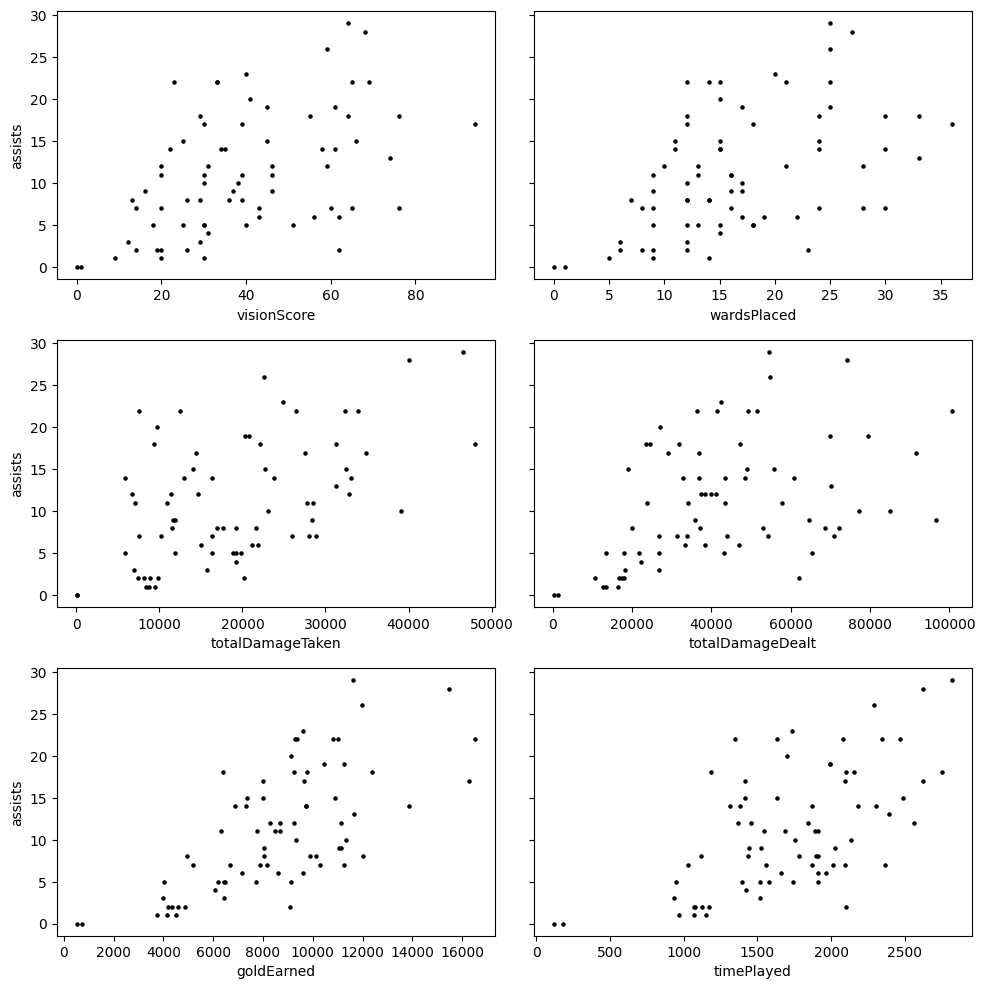

In [4]:
f,axs = plt.subplots(3,2,figsize=(10,10),sharey=True)

_vars = ['visionScore', 'wardsPlaced','totalDamageTaken','totalDamageDealt','goldEarned','timePlayed']

for i,_ax in enumerate(axs.flatten()):
    myMatchesDf.plot.scatter(x=_vars[i],y='assists',ax=_ax,s=5,c='k')

f.tight_layout()

Use lmplot on the graphs that had a possible linear relationship to get an even better estimate

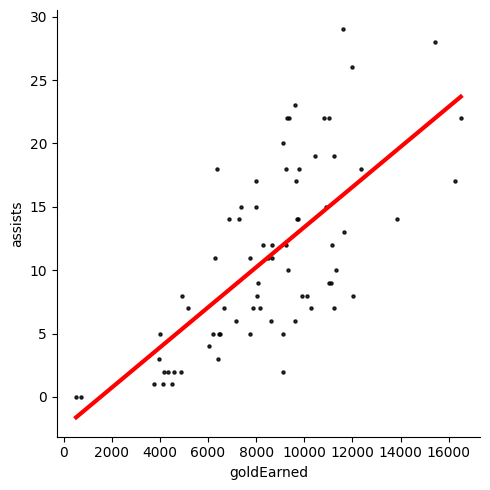

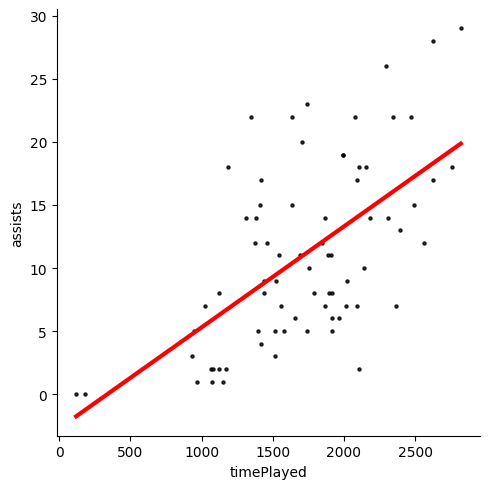

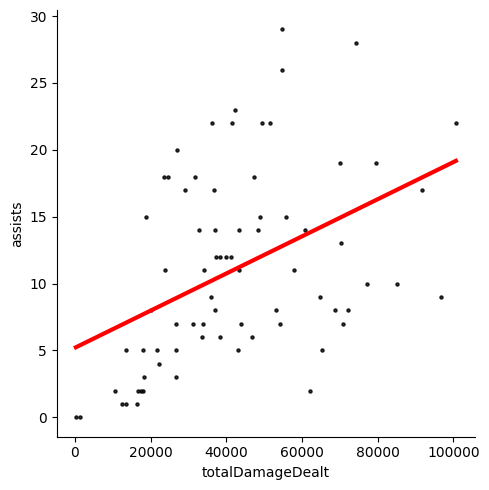

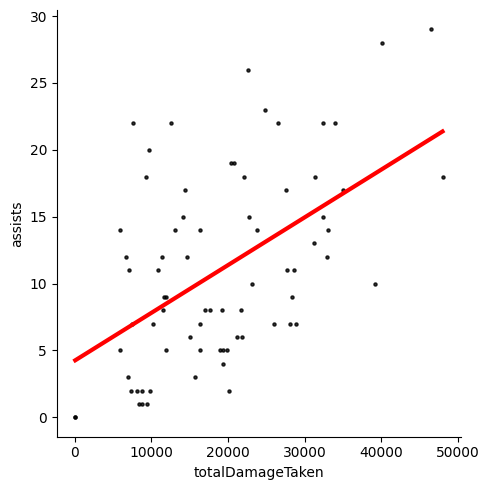

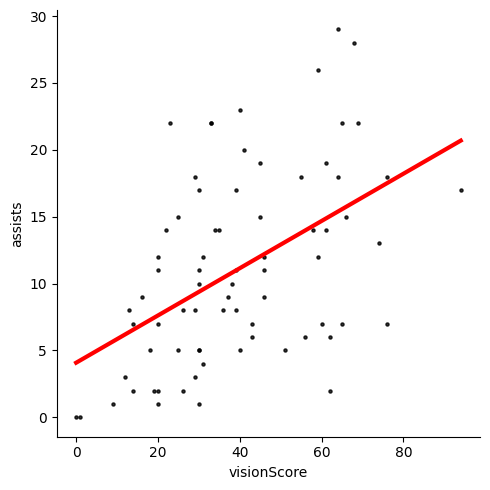

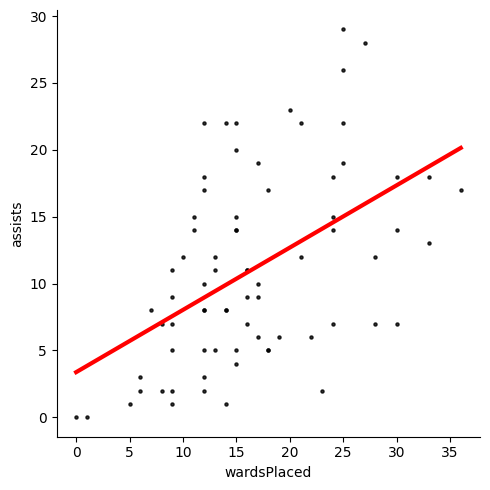

In [5]:
sb.lmplot(x='goldEarned',y='assists',data=myMatchesDf,
              ci=0,line_kws={'color':'r','lw':3},scatter_kws={'color':'k','s':5})
sb.lmplot(x='timePlayed',y='assists',data=myMatchesDf,
              ci=0,line_kws={'color':'r','lw':3},scatter_kws={'color':'k','s':5})
sb.lmplot(x='totalDamageDealt',y='assists',data=myMatchesDf,
              ci=0,line_kws={'color':'r','lw':3},scatter_kws={'color':'k','s':5})
sb.lmplot(x='totalDamageTaken',y='assists',data=myMatchesDf,
              ci=0,line_kws={'color':'r','lw':3},scatter_kws={'color':'k','s':5})
sb.lmplot(x='visionScore',y='assists',data=myMatchesDf,
              ci=0,line_kws={'color':'r','lw':3},scatter_kws={'color':'k','s':5})
sb.lmplot(x='wardsPlaced',y='assists',data=myMatchesDf,
              ci=0,line_kws={'color':'r','lw':3},scatter_kws={'color':'k','s':5})

Correlate all of the variables to check for multicollinearity

<Axes: >

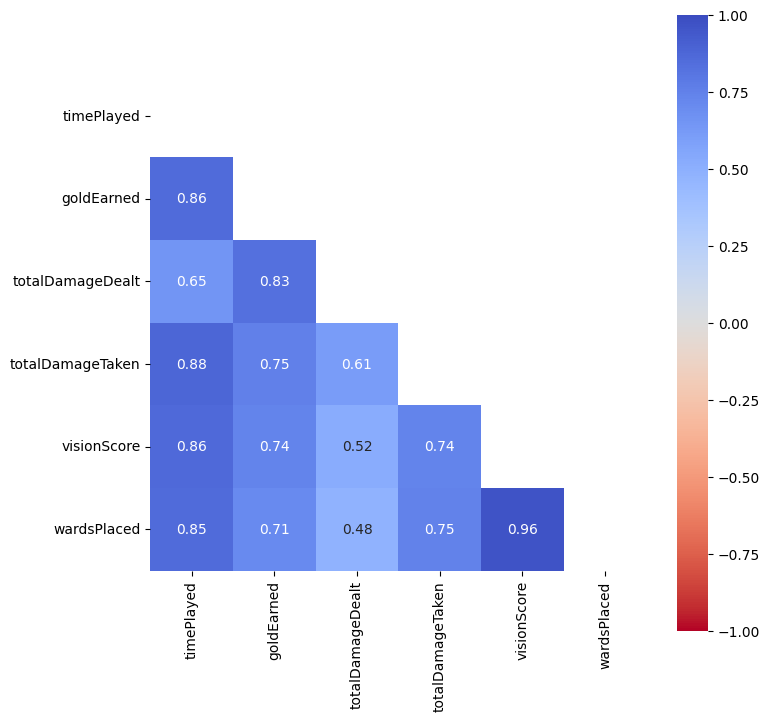

In [6]:
matchCorr =  myMatchesDf[['timePlayed','goldEarned','totalDamageDealt','totalDamageTaken','visionScore','wardsPlaced']].corr()

matchMask = np.zeros_like(matchCorr)
matchMask[np.triu_indices_from(matchMask)] = True

# Set up the plotting environment
f,ax = plt.subplots(1,1,figsize=(8,8))

# Make a heatmap
sb.heatmap(matchCorr,vmin=-1,vmax=1,mask=matchMask,annot=True,square=True,ax=ax,cmap='coolwarm_r')

From the above graph we can see that there is a high amount of colinearity. This isn't detrimental but important to take into account

## Applying Pearson Correlation Coefficient Tests


In [7]:
_vars = ['timePlayed','goldEarned','totalDamageDealt','totalDamageTaken','visionScore','wardsPlaced']
data = []
for _var in _vars:
  r, p_value = pearsonr(myMatchesDf['assists'], myMatchesDf[_var])
  data.append([_var,r,p_value])

corrDf = pd.DataFrame(data, columns=['var','r Value', 'p value'])
corrDf = corrDf.set_index('var')
corrDf

,r Value,p value
var,,
timePlayed,0.599143,1.705635e-08
goldEarned,0.683282,1.979509e-11
totalDamageDealt,0.432922,1.169342e-04
totalDamageTaken,0.520633,1.984228e-06
visionScore,0.486748,1.095673e-05
wardsPlaced,0.497307,6.559746e-06


## Linear Regression Model

In [8]:
model = smf.ols(formula = 'assists ~ timePlayed + goldEarned + totalDamageDealt + totalDamageTaken + visionScore + wardsPlaced',data=myMatchesDf).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                assists   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     13.09
Date:                Wed, 01 May 2024   Prob (F-statistic):           9.65e-10
Time:                        08:11:22   Log-Likelihood:                -221.74
No. Observations:                  74   AIC:                             457.5
Df Residuals:                      67   BIC:                             473.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -4.3435      2.553     -1.701      0.094      -9.440       0.753
timePlayed           0.0005      0.004      0.140      0.889      -0.007       0.008
goldEarned           0.0026      0.001      4.986      0.000       0.002       0.004
totalDamageDealt    -0.0002    5.1e-05     -2.959      0.004      -0.000   -4.91e-05
totalDamageTaken  2.246e-05      0.000      0.187      0.852      -0.000       0.000
visionScore         -0.1291      0.118     -1.092      0.279      -0.365       0.107
wardsPlaced          0.1850      0.301      0.615      0.540      -0.415       0.785
==============================================================================
Omnibus:                        2.018   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.365   Jarque-Bera (JB):                2.003
Skew:                           0.347   Prob(JB):                        0.367
Kurtosis:                       2.589   Cond. No.                     2.26e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.26e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
model2 = smf.ols(formula = 'assists ~ timePlayed + goldEarned + totalDamageDealt + totalDamageTaken',data=myMatchesDf).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                assists   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     19.35
Date:                Wed, 01 May 2024   Prob (F-statistic):           1.03e-10
Time:                        08:11:25   Log-Likelihood:                -222.61
No. Observations:                  74   AIC:                             455.2
Df Residuals:                      69   BIC:                             466.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -3.0515      2.323     -1.314      0.193      -7.686       1.583
timePlayed          -0.0014      0.003     -0.471      0.639      -0.007       0.005
goldEarned           0.0026      0.001      4.936      0.000       0.002       0.004
totalDamageDealt    -0.0001   4.96e-05     -2.991      0.004      -0.000   -4.94e-05
totalDamageTaken  3.678e-05      0.000      0.310      0.757      -0.000       0.000
==============================================================================
Omnibus:                        1.840   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.399   Jarque-Bera (JB):                1.817
Skew:                           0.314   Prob(JB):                        0.403
Kurtosis:                       2.559   Cond. No.                     2.07e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.07e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
model3 = smf.ols(formula = 'assists ~ timePlayed + goldEarned',data=myMatchesDf).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                assists   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     31.17
Date:                Wed, 01 May 2024   Prob (F-statistic):           1.92e-10
Time:                        08:11:28   Log-Likelihood:                -227.13
No. Observations:                  74   AIC:                             460.3
Df Residuals:                      71   BIC:                             467.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.7381      2.082     -1.315      0.193      -6.889       1.413
timePlayed     0.0007      0.002      0.295      0.769      -0.004       0.005
goldEarned     0.0015      0.000      3.805      0.000       0.001       0.002
==============================================================================
Omnibus:                        3.994   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.136   Jarque-Bera (JB):                3.581
Skew:                           0.456   Prob(JB):                        0.167
Kurtosis:                       2.426   Cond. No.                     3.11e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.11e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""